In [ ]:

import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the VGG19 model
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# Function to load and preprocess an image
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image.to(device)

In [ ]:
# Load content and style images
content = load_image('/content/content.jpeg')
style1 = load_image('/content/style1.jpeg', shape=content.shape[-2:])
style2 = load_image('/content/style2.jpeg', shape=content.shape[-2:])


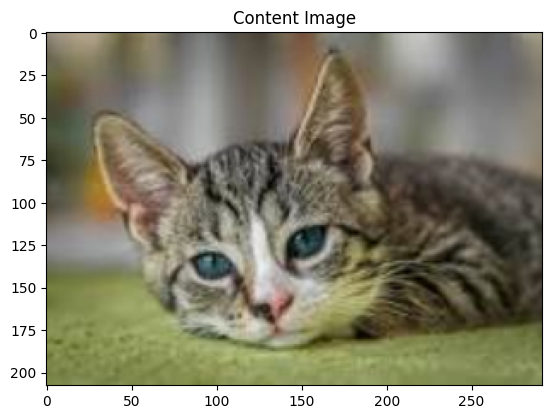

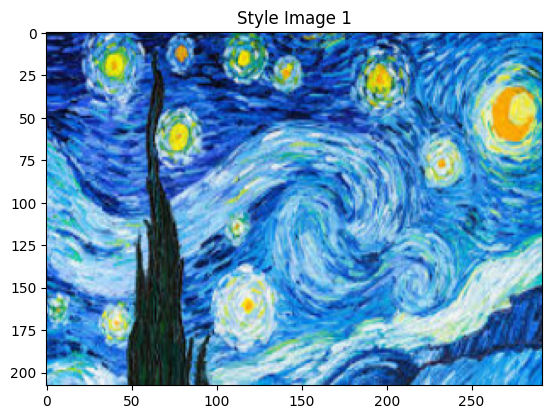

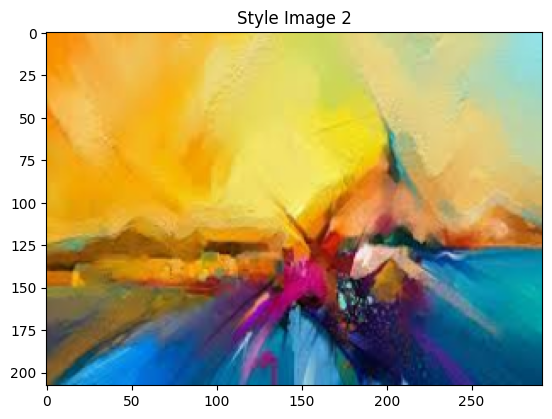

In [ ]:
# Display the images
def imshow(image, title=None):
    image = image.squeeze().cpu().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

imshow(content, title='Content Image')
imshow(style1, title='Style Image 1')
imshow(style2, title='Style Image 2')


In [ ]:
# Initialize the target image as a copy of the content image
target = content.clone().requires_grad_(True).to(device)

# Define loss and optimization
content_weight = 1
style_weight = 1e6
optimizer = optim.Adam([target], lr=0.03)


In [ ]:
# Calculate Gram matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [ ]:
# Get features from the VGG19 model
def get_features(image, model):
    layers = {'0': 'conv1_1',
              '5': 'conv2_1',
              '10': 'conv3_1',
              '19': 'conv4_1',
              '21': 'conv4_2',
              '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


In [ ]:
# Define weights for style layers
style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

In [ ]:
# Define loss and optimization
content_weight = 1
style_weight = 1e6
optimizer = optim.Adam([target], lr=0.03)

Total loss: 68.07640716799999 at step 100


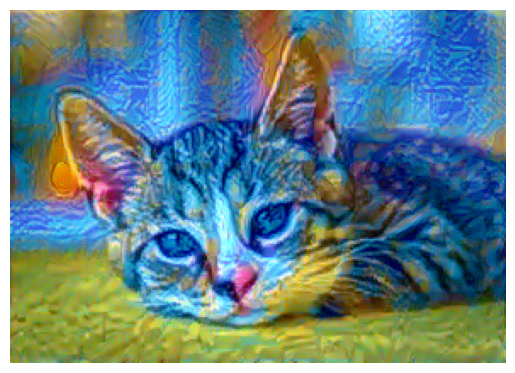

Total loss: 66.253232512 at step 200


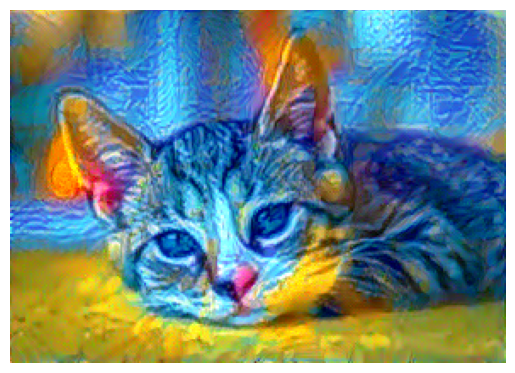

Total loss: 65.823545728 at step 300


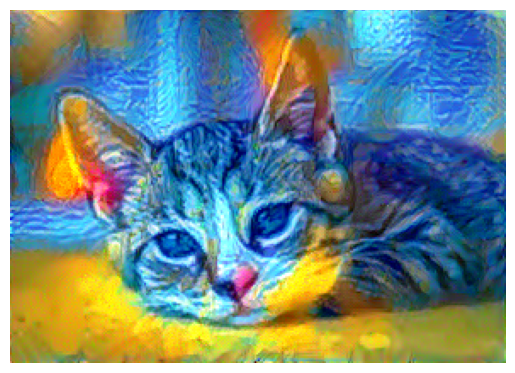

Total loss: 65.71128256 at step 400


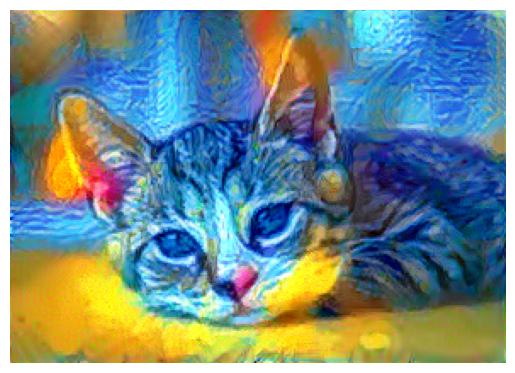

Total loss: 65.666382208 at step 500


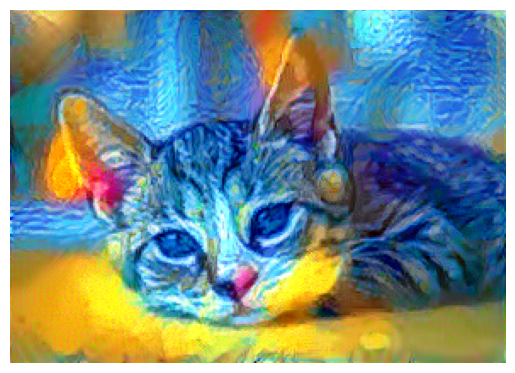

Total loss: 65.64110988799999 at step 600


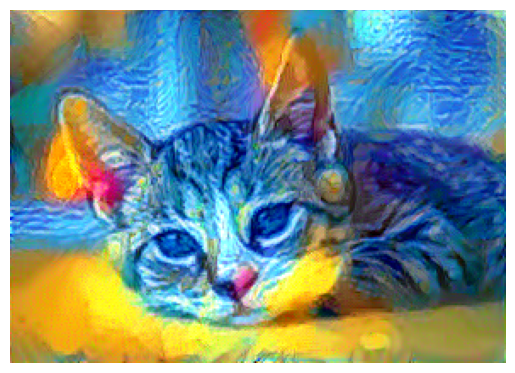

Total loss: 65.624439168 at step 700


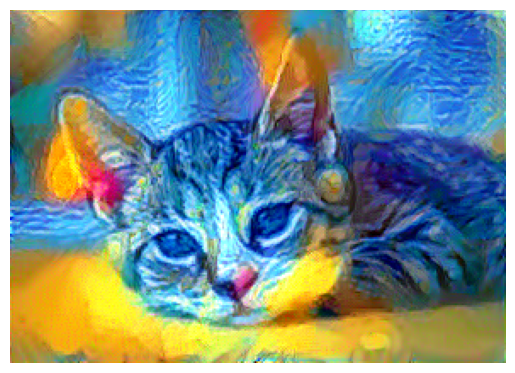

Total loss: 65.612413312 at step 800


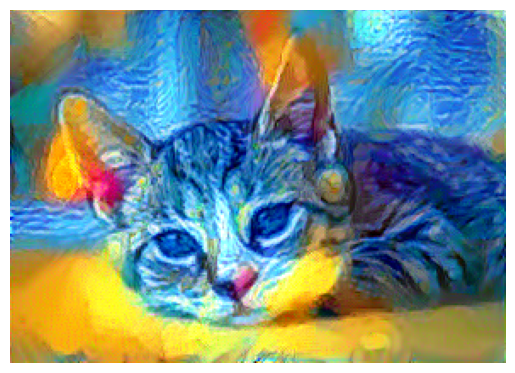

Total loss: 65.60337344 at step 900


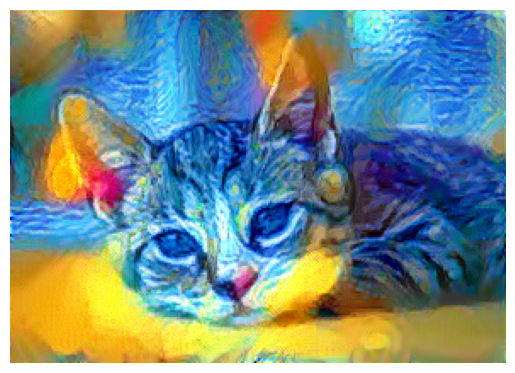

Total loss: 65.596336512 at step 1000


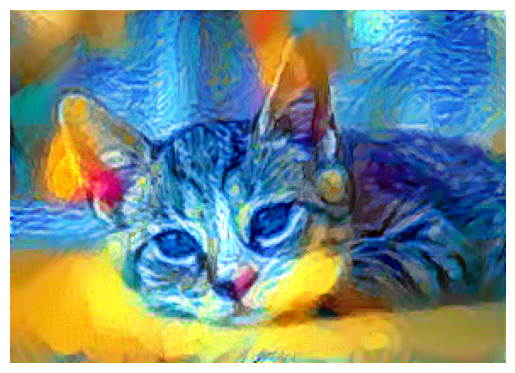

In [ ]:
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

# Get content features for the content image
content_features = get_features(content, vgg)

# Get style features for style 1 and style 2
style1_features = get_features(style1, vgg)
style2_features = get_features(style2, vgg)

# Multi-style transfer
steps = 1000
show_every = 100
for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style1_grams = {layer: gram_matrix(style1_features[layer]) for layer in style1_features}
        style2_grams = {layer: gram_matrix(style2_features[layer]) for layer in style2_features}
        d, h, w = target_feature.shape[:3]
        layer_style_loss1 = style_weights[layer] * torch.mean((target_gram - style1_grams[layer])**2)
        layer_style_loss2 = style_weights[layer] * torch.mean((target_gram - style2_grams[layer])**2)
        style_loss += (layer_style_loss1 + layer_style_loss2) / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if ii % show_every == 0:
        print(f"Total loss: {(total_loss.item())/(10**9)-0.01} at step {ii}")
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()
